# Gradient boosting

In this notebook, we ask you to use the Extreme Gradient Boosting (`xgboost`) algorithm to predict mode choice.

Make use of the processed `train_validate` dataset stored in the `data` subdirectory (`train_validate.csv`), remembering to remove the ID/context columns (see notebooks from previous exercises). Recall that you applied one-hot encoding to the categorical features (look back to the previous notebooks if you don't remember!)


Tasks:

1. Install `xgboost` using `conda` or `pip`


2. Investigate the documentation for `xgboost`, focusing on the `sklearn` api (see [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn))


3. Repeat the steps you applied for the `RandomForestClassifier`. You will need to set the objective to `multi:softprob`. Again, you can set `n_estimators=10` and `n_jobs=-1` to use all available cores for parallelisation. 
    * How does the performance/fit times differ to RF using default parameters
    * If you have time, investigate how performance changes, focusing on `learning_rate` and `n_estimators`

# Get the data

First, we get the data and split them as usual.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import time

import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import matplotlib

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
df_train_validate = pd.read_csv('data/train_validate.csv', index_col='trip_id')

In [3]:
target = ['travel_mode']
id_context = ['trip_id', 
              'household_id', 
              'person_n', 
              'trip_n',
              'survey_year',
              'travel_year'
             ]
features = [c for c in df_train_validate.columns 
            if c not in (target + id_context)]

y = df_train_validate[target]
X = df_train_validate[features]

In [4]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train the first model

In [6]:
%%time

clas = xgb.XGBClassifier(objective='multi:softprob',
                         n_estimators = 10,
                       n_jobs=-1)

clas.fit(X_train, y_train)

/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 5.63 s, sys: 46 ms, total: 5.67 s
Wall time: 5.7 s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [7]:
y_pred = clas.predict(X_validate)

In [8]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels

def acc_pre_rec(y_true, y_pred, verbose=False):
    ''' Returns accuracy, precision, and recall together. 
    If verbose is set to True, it prints the scores for 
    each mode.'''
    acc = accuracy_score(y_true, y_pred)
    prec, rec, fsc, sup = precision_recall_fscore_support(
        y_true, y_pred)
    
    if verbose:
        print("Accuracy: \n    {:.3f}%".format(acc*100))
        scrs = ['Precision', 'Recall']
        for i, scr in enumerate([prec, rec]):
            str_ = '%;\n    '.join(
                "{} - {:.3f}".format(classes[i], 100*s) 
                for i, s in enumerate(scr)
            )
            print("{}: \n    {}%".format(scrs[i], str_))
    else:
        return acc, prec, rec

classes = np.array(['walk', 'cycle', 'pt', 'drive'])

In [9]:
acc_pre_rec(y_validate, y_pred, True)

Accuracy: 
    76.191%
Precision: 
    walk - 72.743%;
    cycle - 0.000%;
    pt - 77.116%;
    drive - 76.611%
Recall: 
    walk - 64.918%;
    cycle - 0.000%;
    pt - 75.777%;
    drive - 85.493%


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization:


array([[1225,    0,  235,  427],
       [  52,    0,  130,  117],
       [ 198,    0, 2925,  737],
       [ 209,    0,  503, 4196]])

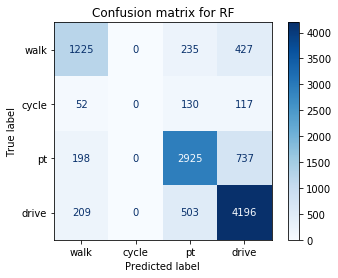

In [11]:
print('Confusion matrix, without normalization:')
display(confusion_matrix(y_validate, y_pred))

fig, ax = plt.subplots()
plot_confusion_matrix(clas, X_validate, y_validate, display_labels= classes, values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix for RF')
plt.show()

It's really difficult to compare the results of the Gradient boosting and the RF since they don't have the same initial parameters. It is thus required to do a parameter search to find the best parameters and have a real idea of what's happening. 

In [12]:
pred_proba = clas.predict_proba(X_validate)

In [13]:
pred_proba

array([[0.1111615 , 0.11587603, 0.5995482 , 0.17341428],
       [0.03774299, 0.05510769, 0.1274027 , 0.77974665],
       [0.03019468, 0.06984379, 0.340032  , 0.5599295 ],
       ...,
       [0.03600593, 0.03378881, 0.11760163, 0.81260365],
       [0.0606667 , 0.03748842, 0.04475502, 0.8570899 ],
       [0.0307854 , 0.03051526, 0.13285778, 0.8058416 ]], dtype=float32)

The probas are correctly calculated (and not only ratios) and that's why it looks this way. 

In [14]:
log_loss(y_validate, pred_proba)

0.6544955468125967

# Parameters exploration

As we've done with RF, we'll do a parameter exploration for the gradient boosting

In [15]:
max_depth = [100, 50, 20, 10, 5, 2, 1]

n_estimators = [200, 100, 10, 5, 2, 1]

In [16]:
# Matrices for the time and the log loss
times = np.zeros((len(max_depth), len(n_estimators)))
ll = np.zeros((len(max_depth), len(n_estimators)))

for i, d in enumerate(max_depth):
    for j, est in enumerate(n_estimators):
        
        print("max_depth = {}; n_estimators = {}".format(d, est))
        
        clas = xgb.XGBClassifier(objective='multi:softprob',
                                 max_depth=d,
                                 n_estimators=est,
                                 n_jobs=-1)
        
        start = time.time()
        clas.fit(X_train, y_train)
        stop = time.time()
        
        # Store the times
        times[i,j] = stop-start
        
        pred_proba = clas.predict_proba(X_validate)
        
        # Store the log loss
        ll[i,j] = log_loss(y_validate, pred_proba)
        
        

max_depth = 100; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 100; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 100; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 100; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 100; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 100; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 50; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 50; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 50; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 50; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 50; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 50; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 20; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 20; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 20; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 20; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 20; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 20; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 10; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 10; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 10; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 10; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 10; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 10; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 5; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 5; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 5; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 5; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 5; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 5; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 2; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 2; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 2; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 2; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 2; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 2; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 1; n_estimators = 200


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 1; n_estimators = 100


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 1; n_estimators = 10


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 1; n_estimators = 5


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 1; n_estimators = 2


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth = 1; n_estimators = 1


/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best set of parameters

In [17]:
(best_depth_idx, best_estim_idx) = np.unravel_index(ll.argmin(), ll.shape)

In [18]:
best_depth = max_depth[best_depth_idx]
best_estim = n_estimators[best_estim_idx]

print("Best LL = {:.3f}. Parameters: (max_depth = {}, n_estimators = {})".format(ll.min(), best_depth, best_estim))

Best LL = 0.503. Parameters: (max_depth = 10, n_estimators = 100)


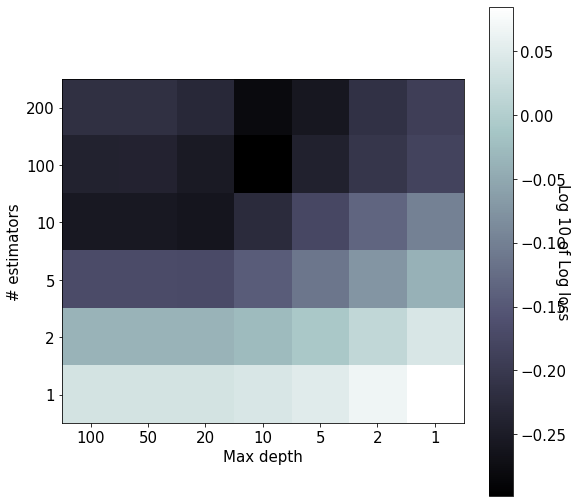

In [19]:
# Bigger font size
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.log10(ll).T, cmap='bone')
cbar = fig.colorbar(cax)

cbar.ax.set_ylabel('Log 10 of Log loss', rotation=270)

plt.xticks(range(len(max_depth)), max_depth)
plt.xlabel('Max depth')

plt.yticks(range(len(n_estimators)), n_estimators)
plt.ylabel('# estimators')

ax.xaxis.set_ticks_position('bottom')


Text(0, 0.5, '# estimators')

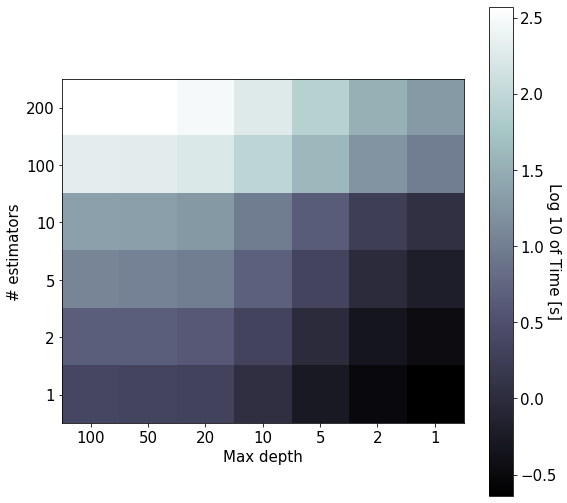

In [20]:
# Bigger font size
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.log10(times).T, cmap='bone')
cbar = fig.colorbar(cax)

cbar.ax.set_ylabel('Log 10 of Time [s]', rotation=270)

plt.xticks(range(len(max_depth)), max_depth)
plt.xlabel('Max depth')
ax.xaxis.set_ticks_position('bottom')

plt.yticks(range(len(n_estimators)), n_estimators)
plt.ylabel('# estimators')

We can now retrain our model with the best parameters and extract the most important features.

In [21]:
clas = xgb.XGBClassifier(objective='multi:softprob',
                         n_estimators=best_estim,
                         max_depth=best_depth,
                         n_jobs=-1)

clas.fit(X_train, y_train)

/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janodypougala/opt/anaconda3/envs/xgb/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [22]:
names = X_train.columns.values

In [23]:
importances = clas.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("{}. {} ({:.3f})".format(f + 1, names[indices[f]], importances[indices[f]]))

Feature ranking:
1. car_ownership (0.208)
2. driving_license (0.063)
3. dur_walking (0.059)
4. dur_pt_rail (0.040)
5. distance (0.033)
6. faretype:free (0.029)
7. cost_driving_total (0.028)
8. bus_scale (0.028)
9. purpose:HBO (0.027)
10. dur_driving (0.024)
11. fueltype:Diesel_LGV (0.023)
12. purpose:HBW (0.023)
13. fueltype:Hybrid_Car (0.022)
14. faretype:full (0.022)
15. purpose:NHBO (0.020)
16. female (0.019)
17. age (0.018)
18. driving_traffic_percent (0.017)
19. purpose:HBE (0.017)
20. cost_transit (0.017)
21. faretype:16+ (0.017)
22. purpose:B (0.016)
23. fueltype:Average_Car (0.015)
24. faretype:dis (0.015)
25. day_of_week (0.014)
26. dur_pt_total (0.014)
27. dur_pt_int_total (0.014)
28. dur_pt_int_waiting (0.013)
29. dur_pt_bus (0.013)
30. dur_pt_access (0.013)
31. travel_month (0.012)
32. travel_date (0.012)
33. start_time_linear (0.012)
34. dur_cycling (0.012)
35. cost_driving_fuel (0.012)
36. fueltype:Diesel_Car (0.011)
37. fueltype:Petrol_Car (0.011)
38. pt_n_interchanges (

Text(0, 0.5, 'Feature importance')

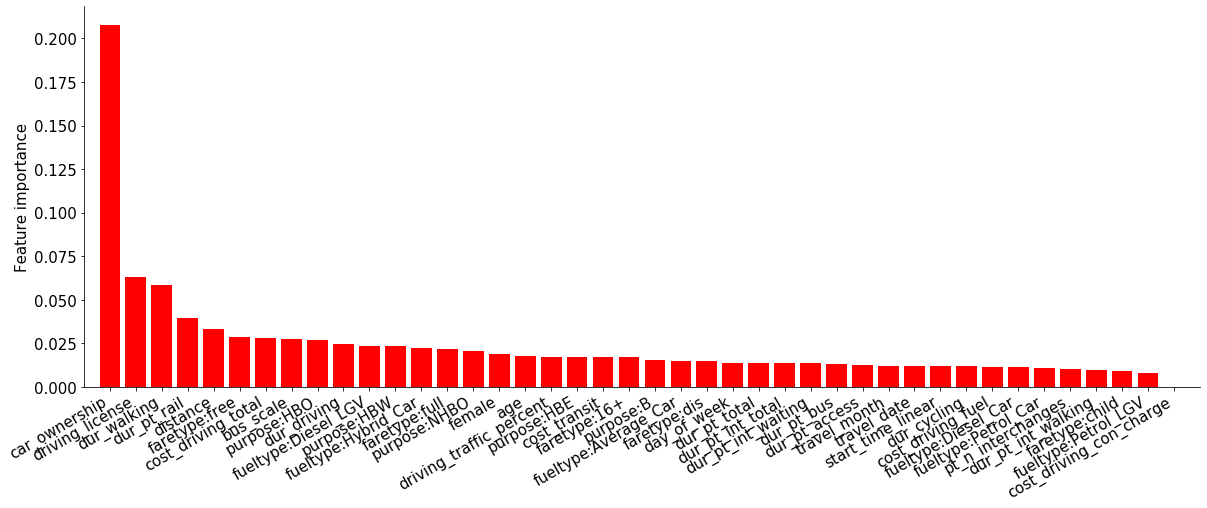

In [24]:
# Plot the feature importances of the XGB classifier

plt.figure(figsize=(20, 7), frameon=False)

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), names[indices])
plt.xlim([-1, X.shape[1]])

for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
    
plt.ylabel('Feature importance')
